In [1]:

## Import Carla and other packages
import carla 
import math 
import random 
import time 
import numpy as np
import cv2
import open3d as o3d
from matplotlib import cm
import glob
import os
import sys
import argparse
from datetime import datetime
import random
import pickle



In [11]:

# Connect the client and set up bp library and spawn point
client = carla.Client('localhost', 2000)
world = client.get_world()
bp_lib = world.get_blueprint_library() 
spawn_points = world.get_map().get_spawn_points() 

In [12]:
world.load_map_layer(carla.MapLayer.Ground)

In [13]:
#Unload all the unwaned things from the world

world.unload_map_layer(carla.MapLayer.Foliage)
world.unload_map_layer(carla.MapLayer.Buildings)
world.unload_map_layer(carla.MapLayer.Decals)
world.unload_map_layer(carla.MapLayer.ParkedVehicles)
world.unload_map_layer(carla.MapLayer.Props)
world.unload_map_layer(carla.MapLayer.StreetLights)
world.unload_map_layer(carla.MapLayer.Walls)
world.unload_map_layer(carla.MapLayer.Particles)
world.load_map_layer(carla.MapLayer.Ground)

In [19]:
##Selecting a spawn point for the ego vehicle
spawnPoint=carla.Transform(carla.Location(x=0,y=0, z=0.598),carla.Rotation(pitch=0.0, yaw=0.0, roll=0.000000))
#Spawn Ego vehicle
Ego_Vehicle_bp = bp_lib.find('vehicle.lincoln.mkz_2020') 
Ego_Vehicle = world.try_spawn_actor(Ego_Vehicle_bp, spawnPoint)



In [24]:
# Move spectator to view ego vehicle
spectator = world.get_spectator() 
transform = carla.Transform(Ego_Vehicle.get_transform().transform(carla.Location(x=-40,z=15,y=0)),Ego_Vehicle.get_transform().rotation) 
spectator.set_transform(transform)

In [21]:
##Selecting a random spawn point for the target vehicle
spawnPoint1=carla.Transform(carla.Location(x=5,y=0, z=0.598),carla.Rotation(pitch=0.0, yaw=-45.0, roll=0.000000))
#Spawn Target vehicle
Target_Vehicle_bp = bp_lib.find('vehicle.jeep.wrangler_rubicon') 
Target_Vehicle = world.try_spawn_actor(Target_Vehicle_bp, spawnPoint1)


In [17]:
Target_Vehicle.destroy()

True

In [18]:
Ego_Vehicle.destroy()

True

In [ ]:
##get the bounding box location of Target Vehicle
"""
box1 = Target_Vehicle.bounding_box
print(box.get_local_vertices)         # Location relative to the vehicle.
print(box.extent) 
print(spawnPoint.location)  
print(spawnPoint) 
print(carla.Transform(box.location))       # XYZ half-box extents in meters.
if carla.BoundingBox.contains(box,spawnPoint.location,carla.Transform(box.location)):
    print('True')
"""

In [ ]:
for actor in world.get_actors().filter('*lidar*'):
    actor.destroy()

for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()

In [11]:
def process_lidar_sematic(point_cloud):
    # data.save_to_disk(parent_path + 'semantic-%06d.ply' % data.frame_number)
    parent_path='/home/santhanam.17/Carla_scripts/point/'

    #Extracting the raw data
    data = np.frombuffer(point_cloud.raw_data, dtype=np.dtype([
        ('x', np.float32), ('y', np.float32), ('z', np.float32),
        ('CosAngle', np.float32), ('ObjIdx', np.uint32), ('ObjTag', np.uint32)]))
    
    data_updated=data[data['ObjTag']==10]
    
    points_temp = np.array([data_updated['x'], data_updated['y'], data_updated['z']]).T
    point_list=o3d.geometry.PointCloud()
    point_list.points = o3d.utility.Vector3dVector(points_temp)
    o3d.io.write_point_cloud("/home/santhanam.17/Carla_scripts/point/"+str(point_cloud.frame)+".ply", point_list)

    #carla.LidarMeasurement.save_to_disk(points_new,"/home/santhanam.17/Carla_scripts/point/a.ply")
    #print(points)

In [12]:
def start_lidar():
    # --------------
    # Add a new LIDAR sensor to my ego
    lidar_bp = world.get_blueprint_library().find('sensor.lidar.ray_cast_semantic')
    lidar_bp.set_attribute('channels',str(64))
    lidar_bp.set_attribute('points_per_second',str(1280000))
    lidar_bp.set_attribute('rotation_frequency',str(10))
    lidar_bp.set_attribute('range',str(120))
    lidar_bp.set_attribute('upper_fov',str(0))
    lidar_bp.set_attribute('lower_fov',str(-30))
    #lidar_bp.set_attribute('horizontal_fov',str(1))
    lidar_location = carla.Location(0,0,2.5)
    lidar_rotation = carla.Rotation(0,0,0)
    lidar_transform = carla.Transform(lidar_location,lidar_rotation)
    lidar_sen = world.spawn_actor(lidar_bp,lidar_transform,attach_to=Ego_Vehicle)
    #Turn on Lidar and start listening
    lidar_sen.listen(lambda lidar_data: process_lidar_sematic(lidar_data))
    #lidar_sen.listen(lambda point_cloud: point_cloud.save_to_disk('/home/santhanam.17/Carla_scripts/point/%.6d.ply' % point_cloud.frame))
    time.sleep(2)
    #Destro the lidar
    lidar_sen.destroy()

In [9]:
# --------------
# Add a new LIDAR sensor to my ego
lidar_bp = world.get_blueprint_library().find('sensor.lidar.ray_cast_semantic')
lidar_bp.set_attribute('channels',str(64))
lidar_bp.set_attribute('points_per_second',str(1280000))
lidar_bp.set_attribute('rotation_frequency',str(10))
lidar_bp.set_attribute('range',str(120))
lidar_bp.set_attribute('upper_fov',str(0))
lidar_bp.set_attribute('lower_fov',str(-30))
lidar_bp.set_attribute('horizontal_fov',str(1))
lidar_location = carla.Location(0,0,2.5)
lidar_rotation = carla.Rotation(0,0,0)
lidar_transform = carla.Transform(lidar_location,lidar_rotation)
lidar_sen = world.spawn_actor(lidar_bp,lidar_transform,attach_to=Ego_Vehicle)
#Turn on Lidar and start listening
#lidar_sen.listen(lambda lidar_data: process_lidar_sematic(lidar_data))
#lidar_sen.listen(lambda point_cloud: point_cloud.save_to_disk('/home/santhanam.17/Carla_scripts/point/%.6d.ply' % point_cloud.frame))
#time.sleep(1)
#Destro the lidar
lidar_sen.destroy()

True

In [13]:
def merge_ply():
        # assign directory
        directory = '/home/santhanam.17/Carla_scripts/point'
        pcds=np.empty([1,3])
        o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Error)
        now = datetime.now()

        current_time = now.strftime("%H:%M:%S")

        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            # checking if it is a file
            if os.path.isfile(f):

                pcd1 = o3d.io.read_point_cloud(f)
                point_cloud_in_numpy = np.asarray(pcd1.points)
                pcds =np.append(pcds,point_cloud_in_numpy,axis=0)
                os.remove(f)

        point_cloud_1 = o3d.geometry.PointCloud()
        point_cloud_1.points = o3d.utility.Vector3dVector(pcds)
        #o3d.io.write_point_cloud("/home/santhanam.17/Carla_scripts/processed/"+str(current_time)+"_Final_Point_cloud.ply", point_cloud,write_ascii=True)
        #final_ply = o3d.io.read_point_cloud("/home/santhanam.17/Carla_scripts/processed/"+str(current_time)+"_sync.ply")
        #o3d.visualization.draw_geometries([final_ply])

        return point_cloud_1


In [73]:
transform=Target_Vehicle.get_transform()
key_tuple=(transform.location.x,transform.location.y,transform.location.z\
            ,transform.rotation.pitch,transform.rotation.yaw,transform.rotation.roll)
print(key_tuple)

(10.0, 3.2924321047289595e-09, 0.1476907730102539, 0.0, 19.999990463256836, 0.0)


In [14]:
def pointcloud_gen():
        #Create a loop to update the location of the target vehicle
        

        dict={}


        for i in range(10,11,1):

            for k in range(0,360,60):

                transform=Target_Vehicle.get_transform()
                transform.location.x = i
                transform.location.y = 0
                transform.rotation.yaw = k

                Target_Vehicle.set_transform(transform)
                #key_tuple=(transform.location.x,transform.location.y,transform.location.z\
                    #,transform.rotation.pitch,transform.rotation.yaw,transform.rotation.roll)
                key_tuple=(transform.location.x,transform.location.y,transform.location.z, transform.rotation.yaw\
                ,i)
                start_lidar()
                point_cloud=merge_ply()
                point_cloud_in_numpy = np.asarray(point_cloud.points)
                dict.update({key_tuple:point_cloud_in_numpy})
            
            with open("/home/santhanam.17/Carla_scripts/point_cloud_database_test.pickle", 'wb') as handle:
                pickle.dump(dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
                #with open('/home/santhanam.17/Carla_scripts/point_cloud_database_main.pickle', 'rb') as handle:
                    #dict = pickle.load(handle)

In [15]:
pointcloud_gen()

[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] Write P

Generated data visualization


In [3]:
st = time.time()
with open('/home/santhanam.17/Carla_scripts/point_cloud_database_test.pickle', 'rb') as handle:
    read_dict = pickle.load(handle)
et= time.time()
Keys=list(read_dict.keys())
pcd =read_dict[Keys[0]]
#print(read_dict.keys())


In [4]:
print(len(read_dict))
print(st-et)
print(Keys[0])
#print(x[281879])

6
-0.014056682586669922
(10.0, 0.0, 0.16079895198345184, 0.0, 10)


In [6]:
from matplotlib import pyplot as plt

104307
104152
5


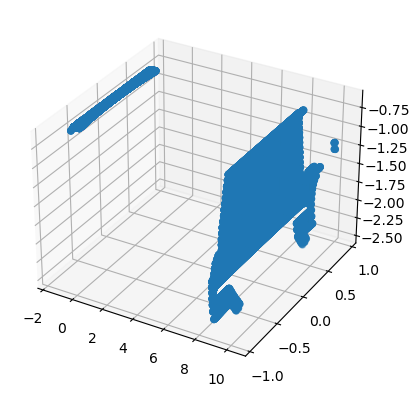

In [7]:
pcd =read_dict[Keys[0]]
print(len(pcd))
pcd = [x for x in pcd if x[0]!=0 and x[1]!=0]
pcd = np.unique(pcd, axis =0)
print(len(pcd))
#print((pcd))
print(len(Keys[1]))

"""point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(pcd)
point_cloud=o3d.geometry.PointCloud.

pcd=np.asarray(point_cloud.points)"""
list_of_x=[x[0] for x in pcd]
list_of_y=[x[1] for x in pcd]
list_of_z=[x[2] for x in pcd]
ax = plt.axes(projection ='3d')

ax.scatter(list_of_x,list_of_y,list_of_z)





In [58]:
print("Load a ply point cloud, print it, and render it")
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(pcd)
#pcd = o3d.io.read_point_cloud(pcd)
o3d.visualization.draw_geometries(point_cloud,
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

print("Downsample the point cloud with a voxel of 0.02")
voxel_down_pcd = point_cloud.voxel_down_sample(voxel_size=0.02)
o3d.visualization.draw_geometries([voxel_down_pcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024])

Load a ply point cloud, print it, and render it


TypeError: draw_geometries(): incompatible function arguments. The following argument types are supported:
    1. (geometry_list: List[open3d.open3d_pybind.geometry.Geometry], window_name: str = 'Open3D', width: int = 1920, height: int = 1080, left: int = 50, top: int = 50, point_show_normal: bool = False, mesh_show_wireframe: bool = False, mesh_show_back_face: bool = False) -> None

Invoked with: geometry::PointCloud with 6621 points.; kwargs: zoom=0.3412, front=[0.4257, -0.2125, -0.8795], lookat=[2.6172, 2.0475, 1.532], up=[-0.0694, -0.9768, 0.2024]

In [5]:
import time

st = time.time()
with open('/home/santhanam.17/Carla_scripts/point_cloud_database_main_optimized_2.pickle', 'rb') as handle:
    read_dict = pickle.load(handle)
et= time.time()
x=list(read_dict.keys())
pcd =read_dict[x[0]]

point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(pcd)

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')
#o3d.visualization.draw_geometries([point_cloud])
#print(pcd)

pcd1 = o3d.io.read_point_cloud("/home/santhanam.17/Carla_scripts/processed/06:36:53sync.ply")
point_cloud_in_numpy = np.asarray(pcd1.points)
print(point_cloud_in_numpy)

Execution time: 0.4033539295196533 seconds
[[ 3.97071390e-316  0.00000000e+000  0.00000000e+000]
 [ 1.00306883e+001  2.08309814e-002 -1.00372279e+000]
 [ 9.47924900e+000 -4.39416260e-001 -1.02928650e+000]
 ...
 [ 8.33544540e+000  8.96605670e-001 -2.35875916e+000]
 [ 8.47096920e+000 -7.22042143e-001 -2.46843600e+000]
 [ 8.46991825e+000  7.05733836e-001 -2.46773386e+000]]
Format = auto
Extension = ply


In [24]:
def add_open3d_axis(vis):
    """Add a small 3D axis on Open3D Visualizer"""
    axis = o3d.geometry.LineSet()
    axis.points = o3d.utility.Vector3dVector(np.array([
        [0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]]))
    axis.lines = o3d.utility.Vector2iVector(np.array([
        [0, 1],
        [0, 2],
        [0, 3]]))
    axis.colors = o3d.utility.Vector3dVector(np.array([
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]]))
    vis.add_geometry(axis)

In [20]:
key=read_dict.keys()
print(list(key)[0])

key_15_0=[b for b in key if b[4]==5 and b[3]==0]
key_15_30=[b for b in key if b[4]==5 and b[3]==30]
key_15_45=[b for b in key if b[4]==5 and b[3]==45]
key_15_90=[b for b in key if b[4]==5 and b[3]==90]

key_45_0=[b for b in key if b[4]==45 and b[3]==0]
key_45_30=[b for b in key if b[4]==45 and b[3]==30]
key_45_45=[b for b in key if b[4]==45 and b[3]==45]
key_45_90=[b for b in key if b[4]==45 and b[3]==90]
print(key_15_0)


(10.0, 0.0, 0.1606035977602005, 0.0, 10)
[]


In [19]:
liust_values=[key_15_0,key_15_30,key_15_45,key_15_90,key_45_0,key_45_30,key_45_45,key_45_90,key_45_90]
print(liust_values[8])
print(read_dict[liust_values[8][0]])

[]


IndexError: list index out of range

In [21]:


now = datetime.now()
current_time = now.strftime("%H:%M:%S")

print(len(liust_values))
for item in liust_values:
    print(item[0])
    point_cloud = o3d.geometry.PointCloud()
    pcd = [x for x in read_dict[item[0]] if x[0]!=0 and x[1]!=0]
    point_cloud.points = o3d.utility.Vector3dVector(pcd)
    
    o3d.io.write_point_cloud("/home/santhanam.17/Carla_scripts/processed/"+str(item[0][0])+"m_"+ str(item[0][3])+"deg"+"_Final_Point_cloud.ply", point_cloud,write_ascii=True)
    time.sleep(1)


9


IndexError: list index out of range

In [9]:
print(read_dict[key_15_0[0]])

[[ 1.19994340e-315  0.00000000e+000  6.21648314e-310]
 [ 1.46992321e+001  1.76237281e-002 -9.78776991e-001]
 [ 1.43659782e+001 -6.10865355e-001 -1.07755303e+000]
 ...
 [ 1.33333654e+001  8.13415229e-001 -2.35540175e+000]
 [ 1.33337164e+001  8.55516672e-001 -2.35592747e+000]
 [ 1.33340855e+001  8.97634923e-001 -2.35647964e+000]]


In [14]:

vis = o3d.visualization.Visualizer()
vis.create_window(
    window_name='Carla Lidar',
    width=1920,
    height=1080,
    left=50,
    top=50)
vis.get_render_option().background_color = [0.05, 0.05, 0.05]
vis.get_render_option().point_size = 1
vis.get_render_option().show_coordinate_frame = True

item = read_dict[Keys[1]]
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(item)
vis.add_geometry(point_cloud)
vis.update_geometry(point_cloud)
vis.poll_events()
vis.update_renderer()
time.sleep(5)
vis.remove_geometry(point_cloud)
vis.destroy_window()

In [ ]:
vis.destroy_window()

visualize Vehicle point cloud using pcl -- next step()
removal of dupilcate points
Lidar Azimuth angle data (*position") - Sloution C
o3d to 
ros publish temporary -Solution B Velodyne64
Full point 
Work on ros node publish, and subscribe random query point
merge point cloud  and publish 
capture rosbag and send the rosnode 

Generate table 

topic 1: background
topic 2: query position 6 dof
topic 3: combined pcl

Algorithm to find the Manhattan distance between the points!


visualize using rviz
Issue:
Generating dataset: 360*60 secs Notebook--- py file run in background ()
[X,Y,Z] search in a list of 12000 points o(n)
[1.1,2.3,3.4]- closest distance. [1,2,3] [8 points]

Publish the pointcloud in ROS - done
Create a dummy ROS Node : Should publish [X,Y,Z,Yaw] (Record and store) Should publish in global coordinate. (Target_vehicle) 10 hz

Another node to subscribe to env pointcloud

Node to subscribe to dummy node. and publish the point cloud.(emulated_pointcloud_pub)
1)Closest point cloud using the (Target_vehicle)

2)Rotate and translate [TO OVERCOME resolution error] [on ~5000 points] (Code to rotate and translate entire pointcloud) Translate on EGO vehicle and rotate around the target vehicle.

3)Add this to the background 

4)Publish the RAW pointcloud

different fixed frame issue.

Carla lidar sensor horizontal angle (This is to reduce the lidar data collection time from 1 sec)








In [ ]:
from scipy.spatial import ConvexHull, Delaunay, cKDTree

# Define the 16 vertices of the convex hull
vertices = [[x1, y1, z1], [x2, y2, z2], ... , [x16, y16, z16]]

# Create a convex hull object
hull = ConvexHull(vertices)

# Create a Delaunay triangulation object
tri = Delaunay(vertices)

# Create a KDTree from the convex hull vertices
tree = cKDTree(vertices)

# Define the point cloud that you want to test for inclusion
point_cloud = [[px1, py1, pz1], [px2, py2, pz2], ... , [pxn, pyn, pzn]]

# Compute the distance between each point in the point cloud and the convex hull
distances, indices = tree.query(point_cloud)

# Determine which points of the point cloud are outside the convex hull
outside_points = point_cloud[distances > 0]

# Print the number of points outside the hull
print("Number of points outside hull:", len(outside_points))


In [2]:
import numpy as np
import pandas as pd
read_Csvfile= pd.read_csv("/home/santhanam.17/Carla_scripts/left_lane_change_scenario.csv")

#loaded_txt= np.loadtxt("/home/santhanam.17/Carla_scripts/left_lane_change_scenario.csv")

In [6]:
num=read_Csvfile.to_numpy()
num

array([[-25. ,   0. ,   0.6],
       [-12. ,   1. ,   0.6],
       [ -9. ,   2. ,   0.6],
       [ -6. ,   3. ,   0.6],
       [ -3. ,   4. ,   0.6],
       [  0. ,   5. ,   0.6],
       [ 10. ,   5. ,   0.6],
       [ 12. ,   4. ,   0.6],
       [ 15. ,   3. ,   0.6],
       [ 18. ,   2. ,   0.6],
       [ 21. ,   1. ,   0.6],
       [ 23. ,   0. ,   0.6],
       [ 25. ,   0. ,   0.6],
       [ 35. ,   0. ,   0.6]])